# Tokenization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from collections import defaultdict
from fastai.text import *
np.random.seed(42)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
path = Path('/home/paperspace/suicides')
lm_path = Path('data/lm/')

In [3]:
df = pd.read_csv(path/'data/std_format_raw_data.csv',index_col=0)

In [4]:
f = Path('data/lm/tmp/tokens.npy')
if not f.is_file():
    texts = df.text.apply(lambda x: 'xbof '+x)
    tok = Tokenizer()
    tokens = []
    for i,text in enumerate(texts):
        tokens.append(tok.proc_text(text))
        if i%(len(texts)//10) == 0:
            print(i/len(texts)*100,' percent done')
    lm_path.mkdir(exist_ok=True)
    (lm_path/'tmp').mkdir(exist_ok=True)
    np.save(lm_path/'tmp'/'tokens.npy', tokens)
else:
    tokens = np.load(lm_path/'tmp'/'tokens.npy')

In [5]:
# get most commonly occuring tokens
freq = Counter(p for o in tokens for p in o)
print('Full vocab size: ',len(freq))
print('Top 20 occuring words:')
freq.most_common(20)

Full vocab size:  377618
Top 20 occuring words:


[('*', 11203884),
 ('\n', 9508265),
 ('.', 6671207),
 ('t_up', 5542099),
 ('-', 3509054),
 (',', 3497876),
 (':', 3433106),
 (']', 2658757),
 ('[', 2523815),
 ('the', 2064814),
 (')', 2061053),
 ('(', 1908151),
 ('and', 1813555),
 ('to', 1522031),
 ('of', 1521027),
 ('was', 1424638),
 ('with', 1085054),
 ('\n\n', 1079766),
 ('/', 1045644),
 ('a', 1009812)]

In [6]:
max_vocab = 150000
min_freq = 2

In [7]:
int_to_str = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
int_to_str.insert(0, '_pad_')
int_to_str.insert(0, '_unk_')
str_to_int = defaultdict(lambda:0, {v:k for k,v in enumerate(int_to_str)})

vocab_size = len(int_to_str)
print('truncated vocab size: ',vocab_size)

truncated vocab size:  118646


# Forward Language Model

In [8]:
f = Path('data/lm/tmp/language_model.npy')
g = Path('data/lm/tmp/int_to_str.npy')
if not (f.is_file() and g.is_file()):
    language_model = np.array([[str_to_int[o] for o in p] for p in tokens])
    np.save(lm_path/'tmp'/'language_model.npy', language_model)
    pickle.dump(int_to_str, open(lm_path/'tmp'/'int_to_str.pkl', 'wb'))
else:
    language_model = np.load(lm_path/'tmp'/'language_model.npy')
    int_to_str = pickle.load(open(lm_path/'tmp'/'int_to_str.pkl', 'rb'))

In [9]:
#! wget -nH -r -np -P {lm_path} http://files.fast.ai/models/wt103/
weights = torch.load(lm_path/'models/wt103/fwd_wt103.h5', map_location=lambda storage, loc: storage)

In [10]:
encoder_weights = to_np(weights['0.encoder.weight'])
row_means = encoder_weights.mean(0)

In [11]:
embedding_size = 400
num_hidden = 1150
num_layers = 3

In [12]:
# key used for wiki103
int_to_str_wiki = pickle.load((lm_path/'models'/'wt103'/'itos_wt103.pkl').open('rb'))
str_to_int_wiki = defaultdict(lambda:-1, {v:k for k,v in enumerate(int_to_str_wiki)})

In [13]:
# map suicide embedding weights to wiki103 embedding weights
new_weights = np.zeros((vocab_size, embedding_size), dtype=np.float32)
for i,w in enumerate(int_to_str):
    row = str_to_int_wiki[w]
    new_weights[i] = encoder_weights[row] if row>=0 else row_means

In [14]:
weights['0.encoder.weight'] = T(new_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

In [15]:
# hyperparameters for language model
wd =1e-7
bptt = 70
bs = 32
lr = 1e-3
opt = partial(optim.Adam, betas=(0.8, 0.99))

In [16]:
size = len(language_model)
lm_train,lm_val = sklearn.model_selection.train_test_split(language_model[:size], test_size=0.1)

dl_train = LanguageModelLoader(np.concatenate(lm_train), bs, bptt)
dl_val = LanguageModelLoader(np.concatenate(lm_val), bs, bptt)
model = LanguageModelData(path, 1, vocab_size, dl_train, dl_val, bs=bs, bptt=bptt)
dropouts = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learner = model.get_model(opt, embedding_size, num_hidden, num_layers, 
    dropouti=dropouts[0], dropout=dropouts[1], wdrop=dropouts[2], dropoute=dropouts[3], dropouth=dropouts[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)
learner.model.load_state_dict(weights)

In [21]:
#learner.lr_find(start_lr=lr/10, end_lr=lr*10, linear=True)
#learner.sched.plot()
#learner.load('lm_last_fit_full')
learner.save_encoder('lm_last_fit_full_encoder')

In [22]:
learner.fit(lr, 1, wds=wd, use_clr=(32,2), cycle_len=1)
learner.save('lm_last_fit_full')
learner.save_encoder('lm_last_fit_full_encoder')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 51/59020 [00:08<2:42:42,  6.04it/s, loss=8.03]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                           
    0      2.871062   2.591112   0.512873  



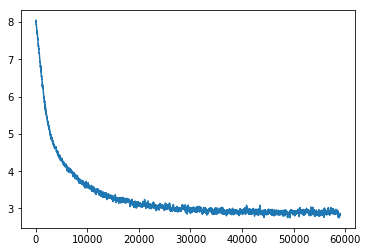

In [25]:
learner.sched.plot_loss()

# Backward Language Model

In [22]:
f = Path('data/lm/tmp/language_model.npy')
g = Path('data/lm/tmp/int_to_str.npy')
if not (f.is_file() and g.is_file()):
    language_model = np.array([[str_to_int[o] for o in p] for p in tokens])
    np.save(lm_path/'tmp'/'language_model.npy', language_model)
    pickle.dump(int_to_str, open(lm_path/'tmp'/'int_to_str.pkl', 'wb'))
else:
    language_model = np.load(lm_path/'tmp'/'language_model.npy')
    int_to_str = pickle.load(open(lm_path/'tmp'/'int_to_str.pkl', 'rb'))

In [23]:
reversed_language_model = []
for doc_vector in language_model:
    reversed_doc_vector = doc_vector[::-1]#[:-1]
    #reversed_doc_vector.insert(0,str_to_int('xbof'))
    reversed_language_model.append(reversed_doc_vector)
reversed_language_model = np.array(reversed_language_model)

In [24]:
weights = torch.load(lm_path/'models/wt103/bwd_wt103.h5', map_location=lambda storage, loc: storage)

In [25]:
encoder_weights = to_np(weights['0.encoder.weight'])
row_means = encoder_weights.mean(0)

In [26]:
embedding_size = 400
num_hidden = 1150
num_layers = 3

In [27]:
# key used for wiki103
int_to_str_wiki = pickle.load((lm_path/'models'/'wt103'/'itos_wt103.pkl').open('rb'))
str_to_int_wiki = defaultdict(lambda:-1, {v:k for k,v in enumerate(int_to_str_wiki)})

In [28]:
# map suicide embedding weights to wiki103 embedding weights
new_weights = np.zeros((vocab_size, embedding_size), dtype=np.float32)
for i,w in enumerate(int_to_str):
    row = str_to_int_wiki[w]
    new_weights[i] = encoder_weights[row] if row>=0 else row_means

In [29]:
weights['0.encoder.weight'] = T(new_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

In [30]:
# hyperparameters for language model
wd =1e-7
bptt = 70
bs = 32
lr = 1e-3
opt = partial(optim.Adam, betas=(0.8, 0.99))

In [31]:
size = len(reversed_language_model)
lm_train,lm_val = sklearn.model_selection.train_test_split(reversed_language_model[:size], test_size=0.1)

dl_train = LanguageModelLoader(np.concatenate(lm_train), bs, bptt)
dl_val = LanguageModelLoader(np.concatenate(lm_val), bs, bptt)
model = LanguageModelData(path, 1, vocab_size, dl_train, dl_val, bs=bs, bptt=bptt)
dropouts = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [32]:
learner = model.get_model(opt, embedding_size, num_hidden, num_layers, 
    dropouti=dropouts[0], dropout=dropouts[1], wdrop=dropouts[2], dropoute=dropouts[3], dropouth=dropouts[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)
learner.model.load_state_dict(weights)

In [19]:
learner.fit(lr, 1, wds=wd, use_clr=(32,2), cycle_len=1)
learner.save('lm_last_fit_full_rev')
learner.save_encoder('lm_last_fit_full_rev_encoder')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                           
    0      3.095271   2.806746   0.486801  

